In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, GLM_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data
from analyses.calc_noise_ceilings import RSA_NOISE_CEILING_DIR, load_mean_std
from notebook_utils import load_results_data, add_avg_subject

In [2]:
def calc_alt_rsas():
    results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

    result_files = sorted(glob(f"{results_root_dir}/*/*/*/results.p"))
    for result_file_path in tqdm(result_files):        
        results = pickle.load(open(result_file_path, 'rb'))

        for metric in ["spearmanr", "pearsonr"]:
            for matrix_metric in ["spearmanr", "pearsonr"]:
                rsa = calc_rsa(results['predictions'], results['latents'], metric, matrix_metric)
                results[f"rsa_{metric}_{matrix_metric}"] = rsa

        pickle.dump(results, open(result_file_path, 'wb'))

# def calc_alt_rsas_imgs_captions():
#     results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

#     result_files = sorted(glob(f"{results_root_dir}/*/*/*/results.p"))
#     for result_file_path in tqdm(result_files):        
#         results = pickle.load(open(result_file_path, 'rb'))
#         results['rsa_images'] = calc_rsa_images(results['predictions'], results['latents'], results['stimulus_types'])
#         results['rsa_captions'] = calc_rsa_captions(results['predictions'], results['latents'], results['stimulus_types'])

#         pickle.dump(results, open(result_file_path, 'wb'))

# calc_alt_rsas()
# calc_alt_rsas_imgs_captions()

In [3]:
def calc_new_rsa():
    fmri_test_betas = dict()
    for subj in SUBJECTS:
        fmri_test_betas[subj], _, _, _ = get_fmri_data(subj, "test", load_mean_std(subj))

    results_root_dir = os.path.expanduser(f'~/data/multimodal_decoding/glm/')

    result_files = sorted(glob(f"{results_root_dir}/*/*/*/results.p"))
    for result_file_path in tqdm(result_files):        
        results = pickle.load(open(result_file_path, 'rb'))
        betas = fmri_test_betas[results['subject']]
        results['rsa_images'] = calc_rsa_images(betas, results['latents'], results['stimulus_types'])
        results['rsa_captions'] = calc_rsa_captions(betas, results['latents'], results['stimulus_types'])

        pickle.dump(results, open(result_file_path, 'wb'))

# calc_new_rsa()

In [4]:
all_data = load_results_data()

MODELS_EXCLUDED = ["bridgetower-large"]
all_data = all_data[~all_data.model.isin(MODELS_EXCLUDED)].copy()

all_data

,alpha,model,subject,features,training_mode,testing_mode,best_val_acc,metric,value,best_val_loss,ensemble,mask,num_voxels,model_feat
0,100000.0,bert-base-uncased,sub-01,lang,modality-agnostic,test,True,rsa,0.147229,NaN,NaN,whole_brain,NaN,bert-base-uncased_lang
1,100000.0,bert-base-uncased,sub-01,lang,modality-agnostic,test,True,rsa_captions,0.076772,NaN,NaN,whole_brain,NaN,bert-base-uncased_lang
2,100000.0,bert-base-uncased,sub-01,lang,modality-agnostic,test,True,rsa_images,0.059800,NaN,NaN,whole_brain,NaN,bert-base-uncased_lang
3,100000.0,bert-base-uncased,sub-01,lang,modality-agnostic,test,True,pairwise_acc,0.861387,NaN,NaN,whole_brain,NaN,bert-base-uncased_lang
4,100000.0,bert-base-uncased,sub-01,lang,modality-agnostic,test,True,pairwise_acc_captions,0.860455,NaN,NaN,whole_brain,NaN,bert-base-uncased_lang
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13315,100000.0,vit-l-16,sub-07,vision,images,test,True,rsa_captions,0.072074,NaN,NaN,whole_brain,NaN,vit-l-16_vision
13316,100000.0,vit-l-16,sub-07,vision,images,test,True,rsa_images,0.131709,NaN,NaN,whole_brain,NaN,vit-l-16_vision
13317,100000.0,vit-l-16,sub-07,vision,images,test,True,pairwise_acc,0.772981,NaN,NaN,whole_brain,NaN,vit-l-16_vision
13318,100000.0,vit-l-16,sub-07,vision,images,test,True,pairwise_acc_captions,0.707039,NaN,NaN,whole_brain,NaN,vit-l-16_vision


In [5]:
all_data_avg = add_avg_subject(all_data)
all_data_avg = all_data_avg[all_data_avg.subject == "average"]

In [6]:
MODEL_ORDER = ["random-flava", "resnet-18", "resnet-50", "resnet-152", "vit-b-16", "vit-l-16", "vit_l_16", "dino-base", "dino-large", "dino-giant",
               "bert-base-uncased", "bert-large-uncased", "gpt2-small", "gpt2-medium", "gpt2-large", "gpt2-xl", "llama2-7b", "llama2-13b", "mistral", "mixtral-8x7b",
               "visualbert", "lxmert", "vilt", "clip", "bridgetower-large", "imagebind", "flava"]

def calc_model_feat_order(data):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODEL_ORDER:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODEL_ORDER:
        for feats in ["vision", "lang", "vision+lang", "multi"]:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

In [7]:
distance_metric = 'cosine'
METRICS = [f'acc_{distance_metric}', f'acc_{distance_metric}_captions', f'acc_{distance_metric}_images']


In [8]:
def plot_metric(data, kind="bar", x_variable="model_feat", order=None, hue_variable="model_feat", hue_order=None, metric="pairwise_acc", ylim=(0.5, 1), plot_legend=True, palette=None,
                noise_ceiling=None, hatches=None, axis=None, marker="o", markersize=5, legend_title="Model features modality", dodge=False):
    data_filtered = data[data.metric == metric]

    sns.set_style("ticks", {'axes.grid' : True})
    if kind == "bar":
        g = sns.barplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette, err_kws={'linewidth': 0.5}, width=0.95)
    elif kind == "point":
        g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
                          errorbar=None, marker=marker, markersize=markersize, markeredgewidth=1, linestyle="none", ax=axis, dodge=dodge)

    g.legend().remove()
    bbox_extra_artists = None
    if plot_legend:
        # lgd = g.legend(loc='upper left', title="", bbox_to_anchor=(0.05, 0.95), ncol=9)
        lgd = g.legend(ncol=3, title=legend_title)
        bbox_extra_artists = (lgd,)

    if noise_ceiling is not None:
        g.axhline(y=noise_ceiling)

    if hatches is not None:
        for i, thisbar in enumerate(g.patches[:len(hatches)]):
            thisbar.set_hatch(hatches[i])

    g.set(ylim=ylim, ylabel=metric, xlabel='')

    # print(g.get_xticklabels())
    # g.set_xticklabels([label.get_text().split('_')[0] for label in g.get_xticklabels()], rotation=80)

    plt.tight_layout()
    
    return g, data_filtered

In [9]:
def plot_metric_catplot(data, kind="bar", x_variable="model_feat", order=None, row_variable="subject", hue_variable="model_feat", hue_order=None, metrics=["pairwise_acc"], ylim=(0.5, 1),
                        plot_legend=True, palette=None, noise_ceilings=None, hatches=None, legend_title="Model features modality"):
    data_filtered = data[data.metric.isin(metrics)]

    sns.set_style("ticks", {'axes.grid' : True})
    g = sns.catplot(data_filtered, kind=kind, x=x_variable, order=order, y="value", row=row_variable, height=4, aspect=4, hue=hue_variable, hue_order=hue_order,
                    palette=palette, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)
   
    g._legend.remove()
    bbox_extra_artists = None
    if plot_legend:
        # lgd = g.fig.legend(loc='upper left', title="", bbox_to_anchor=(1, 0.9), ncol=2)
        lgd = g.fig.legend(ncol=3, title=legend_title, loc="upper left", bbox_to_anchor=(0.05,1))#, bbox_to_anchor=(0.02, 0.95), ncol=9)
        bbox_extra_artists = (lgd,)

    if noise_ceilings is not None:
        for i, ax in enumerate(g.axes):
            ax[0].axhline(y=noise_ceilings[i])

    last_axis = g.axes[-1][0]
    last_axis.set_xticklabels([label.get_text().split('_')[0] for label in last_axis.get_xticklabels()], rotation=80)
    g.set(ylim=ylim, ylabel="pairwise_acc", xlabel='')
    
    plt.tight_layout()
    
    return g, data_filtered

## Modality-agnostic decoding vs. modality-specific decoding

In [10]:
FEAT_ORDER = ["vision", "lang", "vision+lang"]
FEAT_PALETTE = sns.color_palette('Set2')[:3]

def create_result_graph(data, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_variable="features", hue_order=FEAT_ORDER, ylim=None,
                        legend_title="Modality-agnostic decoders based on features from", palette=FEAT_PALETTE, dodge=False, noise_ceilings=None, plot_modality_specific=True):
    data_training_mode_full = data[data.training_mode == "modality-agnostic"]
    data_training_mode_captions = data[data.training_mode == "captions"]
    data_training_mode_images = data[data.training_mode == "images"]

    assert len(data_training_mode_full[(data_training_mode_full.model_feat == 'gpt2-large_lang') & (data_training_mode_full.metric == metrics[0]) & (data_training_mode_full[hue_variable] == data_training_mode_full[hue_variable].values[0])]) == 6

    catplot_g, data_plotted = plot_metric_catplot(data_training_mode_full, order=model_feat_order, metrics=metrics, x_variable="model_feat", legend_title=legend_title,
                                                  hue_variable=hue_variable, row_variable="metric", hue_order=hue_order, palette=palette, ylim=ylim, noise_ceilings=noise_ceilings)

    if plot_modality_specific:
        _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[0, 0], marker="o", plot_legend=False, ylim=ylim)
        g, _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[0], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[0, 0], marker="x", plot_legend=False, ylim=ylim)
        
        _ = plot_metric(data_training_mode_captions, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[1, 0], marker="o", plot_legend=False, ylim=ylim)
        _ = plot_metric(data_training_mode_images, kind="point", order=model_feat_order, metric=metrics[1], x_variable="model_feat", dodge=dodge,
                                      hue_variable=hue_variable, hue_order=hue_order, palette=[(0, 0, 0)], axis=catplot_g.axes[1, 0], marker="x", plot_legend=False, ylim=ylim)
        
        handles, labels = g.get_legend_handles_labels()
        new_labels = ["captions", "images"]
        new_handles = [handles[0], handles[-1]]
        catplot_g.fig.legend(handles=new_handles, labels=new_labels, ncol=2, title="Modality-specific decoders trained on", loc='upper right') #, bbox_to_anchor=(0.05,1)


In [11]:
multimodal_models = all_data_avg[all_data_avg.features == "vision+lang"].model.unique()
MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY = [m+'_lang' for m in multimodal_models] + [m+'_vision' for m in multimodal_models]

<ipython-input-9-922e3bd0884f>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([label.get_text().split('_')[0] for label in last_axis.get_xticklabels()], rotation=80)
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an un

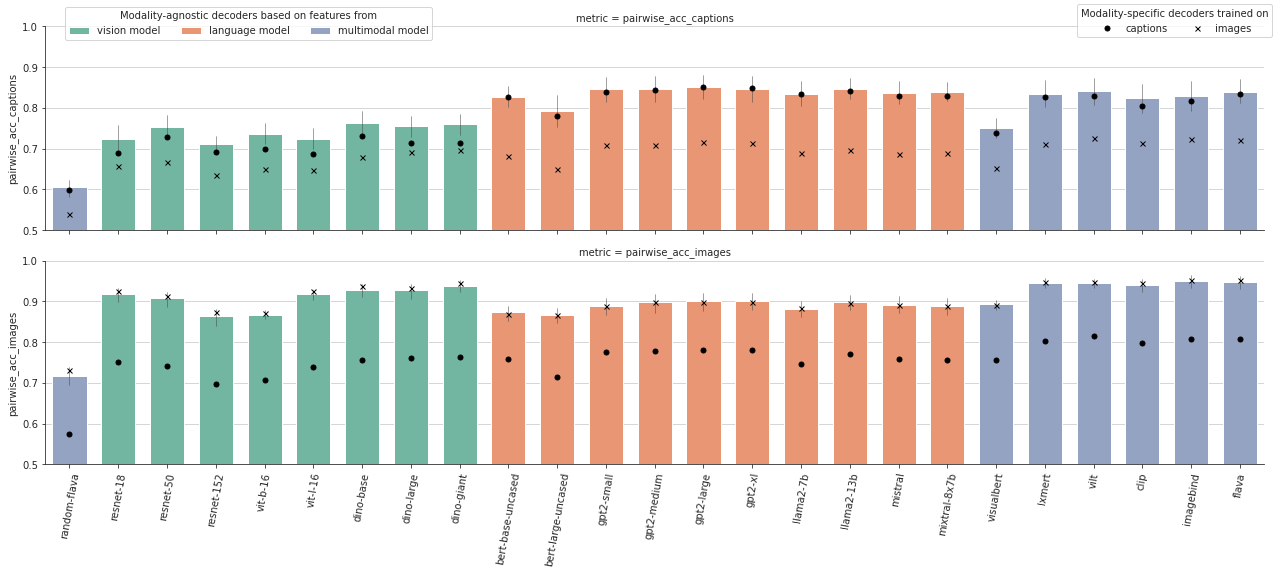

In [12]:
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
# FEAT_ORDER = ["vision", "lang", "vision+lang"]
FEAT_ORDER = ["vision model", "language model", "multimodal model"]

MODEL_FEATS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"] + MODEL_FEAT_MULTIMODAL_SINGLE_MODALITY
data_to_plot = all_data_avg[~all_data_avg.model_feat.isin(MODEL_FEATS_EXCLUDED)].copy()

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision model", "lang": "language model", "vision+lang": "multimodal model"})

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

create_result_graph(data_to_plot, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_order=FEAT_ORDER, ylim=(0.5, 1))
plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc.png"), dpi=300)

In [13]:
# RSA_METRIC = "spearmanr"
# RSA_MATRIX_METRIC = "spearmanr"
# rsa_noise_ceilings_path = os.path.join(RSA_NOISE_CEILING_DIR, f"{RSA_METRIC}_{RSA_MATRIX_METRIC}.p")
# rsa_noise_ceilings = pickle.load(open(rsa_noise_ceilings_path, 'rb'))
# rsa_noise_ceiling_captions_mean = np.mean(list(rsa_noise_ceilings["rsa_captions"].values()))
# rsa_noise_ceiling_images_mean = np.mean(list(rsa_noise_ceilings["rsa_images"].values()))

# create_result_graph(data_no_mask, model_feat_order, metrics=["rsa_captions", "rsa_images"], ylim=(0, 0.2)) #, noise_ceilings=[rsa_noise_ceiling_captions_mean, rsa_noise_ceiling_images_mean])
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_rsa.png"), dpi=300)

In [41]:
sns.color_palette('Set2')[3:8][::-1]

[(0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)]

## ROI-based decoding

<ipython-input-9-922e3bd0884f>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([label.get_text().split('_')[0] for label in last_axis.get_xticklabels()], rotation=80)
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  g = sns.pointplot(data_filtered, x=x_variable, order=order, y="value", hue=hue_variable, hue_order=hue_order, palette=palette,
<ipython-input-8-253b4d8a486d>:9: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an un

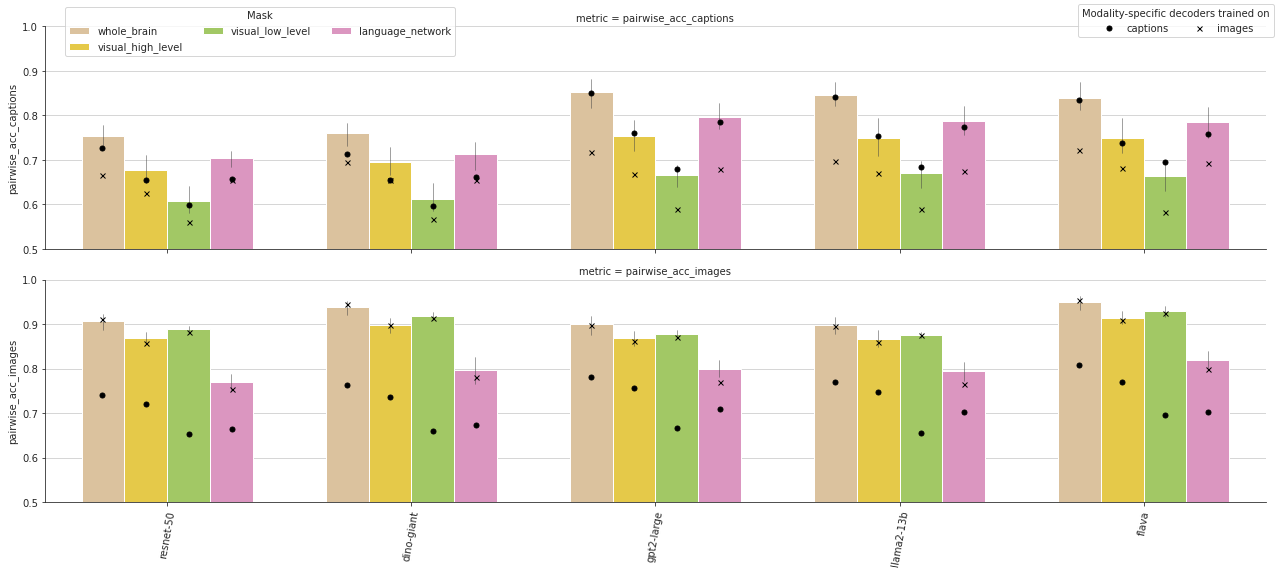

In [44]:
# MASK_ORDER = ["no_mask", "anatomical_visual", "anatomical_visual_occipital", "anatomical_temporal", "anatomical_temporal_exclusive", "anatomical_temporal_not_visual", "anatomical_visual_v1", "anatomical_lang_test", "anatomical_not_visual"]

# MASK_ORDER = ["no_mask", "anatomical_visual_occipital", "anatomical_temporal", "anatomical_temporal_exclusive", "anatomical_visual_v1", "anatomical_lang_test", "anatomical_angular_gyrus", "anatomical_left_angular_gyrus", "anatomical_middle_temporal_gyrus"]
# MASK_ORDER = ["whole_brain", "anatomical_visual_occipital", "anatomical_temporal_exclusive", "anatomical_visual_v1", "anatomical_lang", "anatomical_lang_test", "anatomical_lang_test_2", "anatomical_lang_test_3", "anatomical_lang_test_4", "anatomical_lang_test_5", "anatomical_angular_gyrus", "anatomical_left_angular_gyrus"]
MASK_ORDER = ["whole_brain", "visual_high_level", "visual_low_level", "language_network"]

MASK_PALETTE = sns.color_palette('Set2')[3:3+len(MASK_ORDER)][::-1]
# MASK_PALETTE = sns.color_palette('husl', len(MASK_ORDER))
# MASK_PALETTE = sns.color_palette("Set2")[3:]

# outdated mask:
all_data_avg = all_data_avg[all_data_avg["mask"] != "occipital"]

MODEL_FEATS_INCLUDED = ["resnet-50_vision", "dino-giant_vision", "gpt2-large_lang", "llama2-13b_lang", "flava_vision+lang"]
data_all_masks = all_data_avg[all_data_avg.model_feat.isin(MODEL_FEATS_INCLUDED)].copy()

data_all_masks["mask"] = data_all_masks["mask"].replace({"anatomical_occipital_exclusive": "visual_low_level", "anatomical_lang": "language_network", "anatomical_visual_high_level": "visual_high_level"})

data_all_masks = data_all_masks[data_all_masks["mask"].isin(MASK_ORDER)].copy()

# data_mask = data_training_modes[data_training_modes["mask"] == ROI_MASK]

model_feat_order = calc_model_feat_order(data_all_masks)

create_result_graph(data_all_masks, model_feat_order, metrics=["pairwise_acc_captions", "pairwise_acc_images"], hue_variable="mask", hue_order=MASK_ORDER, palette=MASK_PALETTE, ylim=(0.5, 1), legend_title="Mask", dodge=0.53)

plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_masks.png"), dpi=300)

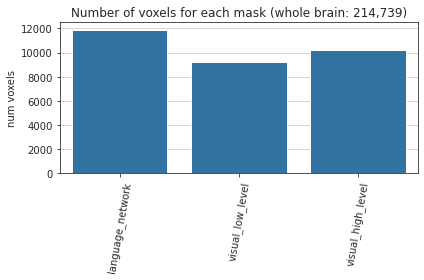

In [27]:
n_voxels_data = data_all_masks[~data_all_masks.num_voxels.isna()]
n_voxels_data = {mask: n_voxels_data[n_voxels_data["mask"] == mask].num_voxels.mean() for mask in n_voxels_data["mask"].unique()}
# n_voxels_data.update({
#     # "whole_brain": 214739,
#     "visual_high_level": 14698,
#     "visual_low_level": 13955
# })
# print(n_voxels_data)
sns.barplot(data=n_voxels_data)
# plt.yscale("log")
plt.xticks(rotation = 80)
plt.ylabel("num voxels")
plt.title("Number of voxels for each mask (whole brain: 214,739)")
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, f"num_voxels.png"), dpi=300)

<ipython-input-9-922e3bd0884f>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  last_axis.set_xticklabels([label.get_text().split('_')[0] for label in last_axis.get_xticklabels()], rotation=80)


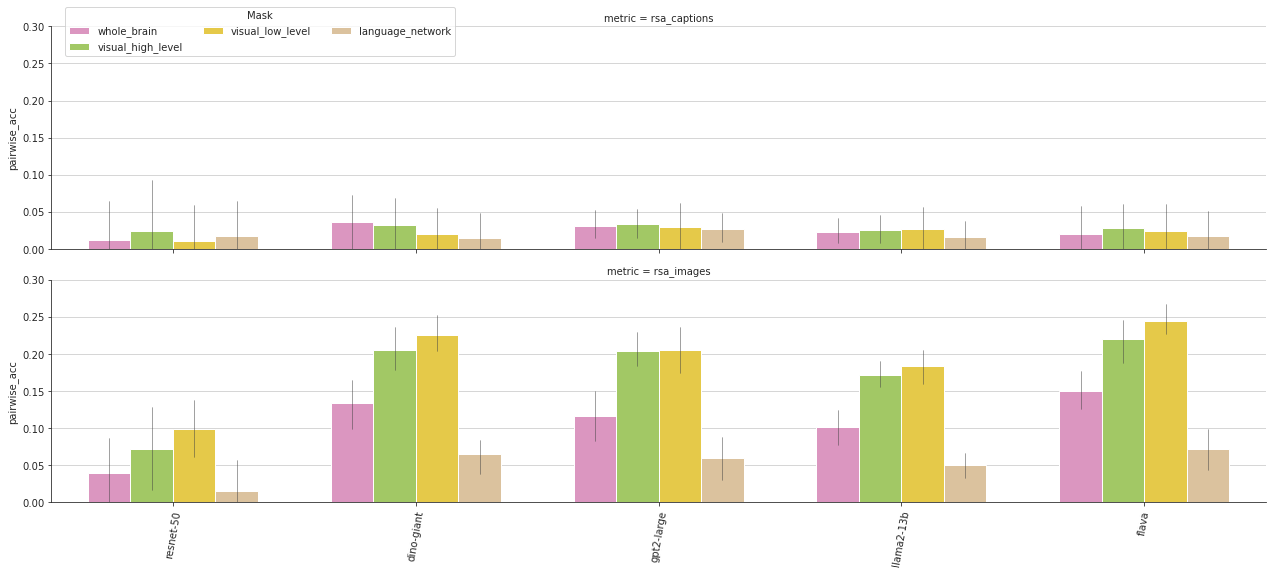

In [28]:
# create_result_graph(data_all_masks, model_feat_order, metrics=["rsa_captions", "rsa_images"], hue_variable="mask", hue_order=MASK_ORDER, palette=MASK_PALETTE, ylim=(0, 0.3), legend_title="Mask", dodge=0.6, plot_modality_specific=False)


## Per-subject results

In [17]:
# data_to_plot = all_data

# MODELS_EXCLUDED = ["bridgetower-large_multi", "random-flava_vision", "random-flava_lang"]
# data_to_plot = all_data[~all_data.model_feat.isin(MODELS_EXCLUDED)].copy()
# data_to_plot = data_to_plot[data_to_plot.training_mode == "train"]
# data_to_plot = data_to_plot[data_to_plot["mask"].isna()]

# model_feat_order = calc_model_feat_order(data_to_plot)
# assert len(data_to_plot[(data_to_plot.model_feat == "flava_lang") & (data_to_plot.metric == "pairwise_acc")]) == 6

# plt.figure(figsize=(15,5))
# g, data_plotted = plot_metric_catplot(data_to_plot, x_variable="model_feat", order=model_feat_order, row_variable="subject", hue_variable="features", hue_order=FEAT_ORDER, palette=FEAT_PALETTE)

# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_pairwise_acc_per_subject.png"), dpi=300)



## RSA noise ceiling

In [18]:
RSA_METRIC = "spearmanr"
RSA_MATRIX_METRIC = "spearmanr"
rsa_noise_ceilings_path = os.path.join(RSA_NOISE_CEILING_DIR, f"{RSA_METRIC}_{RSA_MATRIX_METRIC}.p")
rsa_noise_ceilings = pickle.load(open(rsa_noise_ceilings_path, 'rb'))
rsa_noise_ceiling_captions_mean = np.mean(list(rsa_noise_ceilings["rsa_captions"].values()))
rsa_noise_ceiling_images_mean = np.mean(list(rsa_noise_ceilings["rsa_images"].values()))

# rsa_noise_ceiling_std = np.std(list(rsa_noise_ceilings.values()))
print(rsa_noise_ceiling_captions_mean)
print(rsa_noise_ceiling_images_mean)

# print(rsa_noise_ceiling_std)
# g, _ = plot_metrics(data_to_plot, metrics=["rsa_spearmanr_spearmanr"], ylim=(0, 0.7), palette=palette, hue_order=model_feat_order, noise_ceiling=rsa_noise_ceiling_mean)
# g, _ = plot_metrics(data_to_plot, metrics=["rsa_spearmanr_spearmanr"], ylim=(0, 0.3), palette=palette, hue_order=model_feat_order)


0.016981539366333558
0.15442422589374546


In [19]:
all_data[all_data.best_val_acc == True].alpha.unique()

array([1.e+05, 1.e+03, 1.e+07])

In [20]:

# data_to_print = all_data[(all_data.best_val_acc == True) & (all_data.ensemble != True)]
# data_to_print = data_to_print[data_to_print.subject.isin(["sub-01", "sub-02", "sub-03"])]
# # data_to_print = data_to_print[data_to_print.model_feat.str.contains('bert-large-uncased_lang')]
# data_to_print = data_to_print[data_to_print.model_feat.str.contains('vilt_concat')]

# print(len(data_to_print[data_to_print.metric == "pairwise_acc"].value))
# # assert len(data_to_print[data_to_print.metric == "acc_cosine"].value) == 6
# print(data_to_print[data_to_print.metric == "pairwise_acc"].value.mean())
# data_to_print[data_to_print.metric == "pairwise_acc"]

In [21]:

# data_to_print = all_data[(all_data.best_val_mse == True) & (all_data.ensemble != True)]
# data_to_print = data_to_print[data_to_print.subject == "sub-01"]
# data_to_print = data_to_print[data_to_print.model_feat.str.contains('flava_lang')]
# print(len(data_to_print[data_to_print.metric == "pairwise_acc"].value))
# # assert len(data_to_print[data_to_print.metric == "acc_cosine"].value) == 6
# print(data_to_print[data_to_print.metric == "pairwise_acc"].value.mean())
# data_to_print[data_to_print.metric == "pairwise_acc"]

In [22]:
# base_palette = COLORS_PLOT_CATEGORICAL
# base_palette = [matplotlib.colors.to_rgb(color) for color in base_palette]
# # print(base_palette)
# def model_feat_color_palette(data, model_feat_order):
#     assert len(data.model.unique()) <= len(base_palette)
#     model_to_color = {model: color for model, color in zip(data.model.unique(), base_palette)}
    
#     new_palette = []
#     prev_model = None
#     feat_idx = 0
#     for model_feat in model_feat_order:
#         model = data[data.model_feat == model_feat].iloc[0].model
#         if prev_model != model:
#             prev_model = model
#             feat_idx = 0
#         new_color = model_to_color[model]
#         new_color = [c + feat_idx*0.05 if c + feat_idx*0.1 <=1 else 1 for c in new_color]
#         new_palette.append(new_color)
#         feat_idx += 1
#     return new_palette

In [23]:
# def model_size_color_palette(data, model_order):
#     for model in data.model.unique():
#         if model not in model_order:
#             raise RuntimeError(f"Model missing in order: {model}")
#     data["model_prefix"] = data.model.apply(lambda name: name.split('-')[0] if '-' in name else name.split('_')[0] if '_' in name else name)
#     assert len(data.model_prefix.unique()) <= len(base_palette)
#     model_prefix_to_color = {model_prefix: color for model_prefix, color in zip(data.model_prefix.unique(), base_palette)}
    
#     new_palette = []
#     prev_model_prefix = None
#     feat_idx = 0
#     for model in model_order:
#         filtered = data[data.model == model]
#         if len(filtered) < 1:
#             raise RuntimeError(f"Model missing in data: {model}")
#             continue
#         model_prefix = filtered.iloc[0].model_prefix
#         if prev_model_prefix != model_prefix:
#             prev_model_prefix = model_prefix
#             feat_idx = 0
#         new_color = model_prefix_to_color[model_prefix]
#         new_color = [min(1, c + feat_idx*0.1) for c in new_color]
#         new_palette.append(new_color)
#         feat_idx += 1
#     return new_palette

In [24]:
# FEATS_TO_HATCH = {"vision": '\\\\', "lang": '//', "vision+lang": 'xx'}
# def model_size_hatch_palette(data, model_feat_order):
#     for model in data.model_feat.unique():
#         if model not in model_feat_order:
#             raise RuntimeError(f"Model missing in order: {model}")
#     data["model_prefix"] = data.model.apply(lambda name: name.split('-')[0] if '-' in name else name.split('_')[0] if '_' in name else name)
#     prefixes_ordered = set([name.split('-')[0] if '-' in name else name.split('_')[0] if '_' in name else name for name in model_feat_order])
#     # print(prefixes_ordered)
#     assert len(data.model_prefix.unique()) <= len(base_palette)
#     model_prefix_to_color = {model_prefix: color for model_prefix, color in zip(prefixes_ordered, base_palette)}
#     print({model: matplotlib.colors.to_hex(color) for model, color in model_prefix_to_color.items()})
#     hatches = []
#     new_palette = []
#     prev_model_prefix = None
#     prev_model = None
#     suffix_idx = 2
#     for model_feat in model_feat_order:
#         model = data[data.model_feat == model_feat].iloc[0]
#         if prev_model_prefix != model.model_prefix:
#             prev_model_prefix = model.model_prefix
#             suffix_idx = 2
#         if prev_model != model.model:
#             prev_model = model.model
#             suffix_idx -= 1

#         new_color = model_prefix_to_color[model.model_prefix]
#         new_color = [max(0, min(1, c + suffix_idx*0.15)) for c in new_color]
#         new_palette.append(new_color)
#         hatches.append(FEATS_TO_HATCH[model.features])

#     return new_palette, hatches

In [25]:
# print(data_to_plot[(data_to_plot.model_feat == "gpt2-large_lang") & (data_to_plot.metric == "pairwise_acc")].value.mean())
# print(data_to_plot[(data_to_plot.model_feat == "gpt2-xl_lang") & (data_to_plot.metric == "pairwise_acc")].value.mean())
# print(data_to_plot[(data_to_plot.model_feat == "llama2-13b_lang") & (data_to_plot.metric == "pairwise_acc")].value.mean())
# print(data_to_plot[(data_to_plot.model_feat == "flava_vision+lang") & (data_to_plot.metric == "pairwise_acc")].value.mean())
# print(data_to_plot[(data_to_plot.model_feat == "vilt_vision+lang") & (data_to_plot.metric == "pairwise_acc")].value.mean())
